In [1]:
import os
import pandas as pd
import optuna
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

In [2]:
NUM_QUBITS = 60

SUBCIRCUIT_SIZE = 30
CSV_FILE = "cost2.csv"

In [3]:
from qtpu.compiler.compiler import trial_to_hybrid_tn

def _min_cost_htn(study: optuna.Study) -> qtpu.HybridTensorNetwork:
    best_trial = min(study.best_trials, key=lambda trial: trial.values[0])
    htn = trial_to_hybrid_tn(best_trial)
    assert all(qtn.circuit.num_qubits <= SUBCIRCUIT_SIZE for qtn in htn.quantum_tensors)
    return htn

In [4]:
from benchmark.util import contraction_cost_log10, bruteforce_cost_log10
from qtpu.compiler.terminators import reach_num_qubits


def get_result(circuit: QuantumCircuit) -> dict[str, float]:
    study_only_wire = qtpu.compiler.hyper_optimize(
        circuit,
        terminate_fn=reach_num_qubits(SUBCIRCUIT_SIZE),
        compression_methods=["2q"],
        n_trials=100,
        max_cost=1e12,
        show_progress_bar=True,
    )
    study_normal = qtpu.compiler.hyper_optimize(
        circuit,
        terminate_fn=reach_num_qubits(SUBCIRCUIT_SIZE),
        n_trials=100,
        max_cost=1e12,
        show_progress_bar=True,
    )
    
    return {
        "qtpu": contraction_cost_log10(_min_cost_htn(study_normal)),
        "ckt": bruteforce_cost_log10(_min_cost_htn(study_normal)),
        "cutqc": bruteforce_cost_log10(_min_cost_htn(study_only_wire)),
        "scaleqc": contraction_cost_log10(_min_cost_htn(study_only_wire)),
    }

In [5]:
from benchmark.benchmarks import (
    brick_ansatz,
    linear_ansatz,
    random_ansatz,
    cluster_ansatz,
    ring_ansatz,
    qaoa_regular_ansatz,
    qaoa_powerlaw_ansatz,
)
from qiskit.circuit.random import random_circuit

BENCHMARKS = [
    # (f"qaoa_regular_{NUM_QUBITS}_1", qaoa_regular_ansatz(NUM_QUBITS, 1)),
    # (f"qaoa_power_{NUM_QUBITS}_1", qaoa_powerlaw_ansatz(NUM_QUBITS, 1)),
    # (f"ring_{NUM_QUBITS}_3", ring_ansatz(NUM_QUBITS, 3)),
    # (f"ring_{NUM_QUBITS}_4", ring_ansatz(NUM_QUBITS, 4)),
    # (f"linear_{NUM_QUBITS}_3", linear_ansatz(NUM_QUBITS, 3)),
    # (f"linear_{NUM_QUBITS}_4", linear_ansatz(NUM_QUBITS, 4)),
    # (f"cluster_{25}_8_1", cluster_ansatz([25]*8, 1)),
    # (f"cluster_{25}_8_2", cluster_ansatz([25]*8, 2)),
    (f"cluster_{25}_8_3", cluster_ansatz([25]*8, 3)),
    # (f"random_{NUM_QUBITS}_1", random_circuit(NUM_QUBITS, 1, max_operands=2)),
    # (f"random_{NUM_QUBITS}_2", random_circuit(NUM_QUBITS, 2, max_operands=2)),
    # (f"random_{NUM_QUBITS}_3", random_circuit(NUM_QUBITS, 3, max_operands=2)),
    # (f"random_{NUM_QUBITS}_4", random_circuit(NUM_QUBITS, 4, max_operands=2)),
    # (f"cluster_{25}_4_1", cluster_ansatz([25]*4, 1)),
    # (f"cluster_{25}_4_2", cluster_ansatz([25]*4, 2)),
    # (f"cluster_{25}_4_3", cluster_ansatz([25]*4, 3)),
    # (f"cluster_{25}_4_4", cluster_ansatz([25]*4, 4)),
    # (f"cluster_{25}_4_5", cluster_ansatz([25]*4, 5)),
    # (f"brick_{NUM_QUBITS}_1", brick_ansatz(NUM_QUBITS, 1)),
    # (f"brick_{NUM_QUBITS}_2", brick_ansatz(NUM_QUBITS, 2)),
    # (f"brick_{NUM_QUBITS}_3", brick_ansatz(NUM_QUBITS, 3)),
]

In [6]:
from benchmark.util import append_to_csv

for name, circuit in BENCHMARKS:
    result = get_result(circuit)
    append_to_csv(CSV_FILE, {"name": name, **result})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
from benchmark._plot_util import *

def plot(benches: list[str], ax: plt.Axes):
    df = pd.read_csv(CSV_FILE)
    df = df[["name", "qtpu", "scaleqc", "ckt", "cutqc"]]
    df = df[df["name"].isin(benches)]
    df.sort_index()
    df_mean = 10 ** df.groupby("name").mean() 
    df_std = df.groupby("name").std().reset_index().drop("name", axis=1)

    df_mean.plot.bar(
        rot=20,
        width=0.8,
        edgecolor="black",
        linewidth=2,
        ax=ax,
        # legend=False,
        yerr=df_std.to_numpy().T,
    )
    ax.set_yscale("log")
    # ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
    ax.set_title("Lower is better ↓", fontweight="bold", color="midnightblue")
    ax.set_xlabel("")
    ax.set_ylabel("Contraction Cost [FLOPs]")

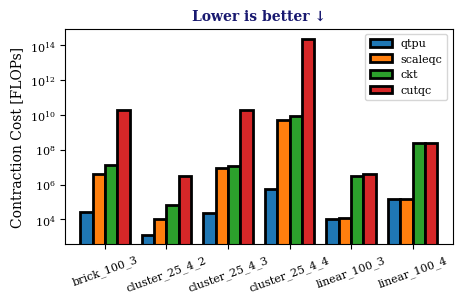

In [6]:
benches_to_plot = [
    # f"qaoa_regular_{NUM_QUBITS}_1",
    # f"qaoa_power_{NUM_QUBITS}_1"
    "cluster_25_4_5",
    "cluster_25_4_4",
    "cluster_25_4_3",
    "cluster_25_4_2",
    # "cluster_25_4_1",
    # "cluster_25_8_4",
    # # "linear_200_1",
    # "linear_100_2",
    "linear_100_3",
    "linear_100_4",

    # # # "brick_100_1",
    # "brick_100_2",
    "brick_100_3",
    "brick_100_4",
]


# df = pd.read_csv(CSV_FILE)
# df = df[df["name"].isin(benches_to_plot)]

# df = df.groupby("name").mean()


# # df.set_index(df.index.str.replace(f"_{NUM_QUBITS}_", "_"), inplace=True)
# # reorder columns
# # df = df[["qtpu", "scaleqc", "ckt", "cutqc"]]
WIDE_FIGSIZE = (5, 2.8)

fig, ax = plt.subplots(figsize=WIDE_FIGSIZE)
plot(benches_to_plot, ax)


# hatches = ['//', '\\\\', '--', 'xx', 'oo', 'OO', '..', '**']


# for i, patch in enumerate(ax.patches):
#     patch.set_hatch(hatches[i % 4])

# import seaborn as sns

# colors = sns.color_palette("tab10", n_colors=4)

# df.plot.bar(rot=15, width=0.8, edgecolor="black", linewidth=2, ax=ax, color=colors, legend=False)

# # for ytick in ax.get_yticklabels():
# # ytick.set_text(f"$10^{{{ytick.get_text()}}}$")

# ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
# ax.set_title("Lower is better", fontweight="bold", color="midnightblue")
# ax.set_xlabel("")
# fig;

In [7]:
fig.savefig("cost.pdf", bbox_inches="tight")